In [1]:
import torch.nn as nn
import math
from omni import ODConv2d, ODConvBN
from mixup import mixup_data, mixup_criterion

__all__ = ['mobilenetv3_large', 'mobilenetv3_small']

In [2]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6

class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, _make_divisible(channel // reduction, 8)),
                nn.ReLU(inplace=True),
                nn.Linear(_make_divisible(channel // reduction, 8), channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

In [3]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6

class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, _make_divisible(channel // reduction, 8)),
                nn.ReLU(inplace=True),
                nn.Linear(_make_divisible(channel // reduction, 8), channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

In [4]:
def conv_3x3(inp, oup, stride, batch_norm = True):
    layers = [
        nn.Conv2d(inp, oup, kernel_size=3, stride=1,
                  padding=1, bias=False),
        h_swish()
    ]#
    if batch_norm:
        layers.insert(1, nn.BatchNorm2d(oup))

    return nn.Sequential(*layers)

def conv_1x1(inp, oup, batch_norm = True):
    layers = [
        nn.Conv2d(inp, oup, kernel_size=1, stride=1,
                  padding=0, bias=False),
        h_swish()
    ]
    if batch_norm:
        layers.insert(1, nn.BatchNorm2d(oup))

    return nn.Sequential(*layers)

In [5]:
def od_conv_1x1(inp, oup, stride = 1, kernel_num = 4,
                temperature = 60,
                batch_norm = True):
    return nn.Sequential(
        ODConvBN(inp, oup, kernel_size = 1, stride = stride,
            kernel_num = kernel_num, temperature = temperature) \
                if batch_norm == True else \
        ODConv2d(inp, oup, kernel_size = 1, stride = stride,
            kernel_num = kernel_num, temperature = temperature),

        h_swish()
    )

def od_conv_3x3(inp, oup, stride = 1,
                kernel_num = 4, temperature = 60,
                batch_norm = True):
    return nn.Sequential(
         ODConvBN(inp, oup, kernel_size = 3, stride = stride,
            kernel_num = kernel_num, temperature = temperature) \
                if batch_norm == True else \
        ODConv2d(inp, oup, kernel_size = 3, stride = stride,
            kernel_num = kernel_num, temperature = temperature),

        h_swish()
    )

In [6]:
class InvertedResidualOD(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size,
                 stride, use_se, use_hs,
                 kernel_num_1 = 4,
                 kernel_num_2 = 4, temperature = 60.0):
        super(InvertedResidualOD, self).__init__()
        assert stride in [1, 2]

        self.identity = stride == 1 and inp == oup
        print("Using OmniDimensional")
        if inp == hidden_dim:
            self.conv = nn.Sequential(
                # dw
                ODConvBN(hidden_dim, hidden_dim, kernel_size, stride,
                         groups=hidden_dim, kernel_num = kernel_num_1,
                         temperature = temperature),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                # pw-linear
                ODConv2d(hidden_dim, oup, 1, 1, kernel_num = kernel_num_2,
                         temperature = temperature),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                ODConvBN(inp, hidden_dim, kernel_size = 1, stride = 1,
                         kernel_num = kernel_num_2, temperature = temperature),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # dw
                ODConvBN(hidden_dim, hidden_dim, kernel_size,
                         stride, groups=hidden_dim, kernel_num = kernel_num_1,
                         temperature = temperature),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # pw-linear
                ODConv2d(hidden_dim, oup, 1, 1, kernel_num = kernel_num_2,
                         temperature = temperature),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


In [7]:
class InvertedResidual(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size, stride, use_se, use_hs):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        self.identity = stride == 1 and inp == oup

        print("Using Normal")
        if inp == hidden_dim:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


# MobileNetV3

In [8]:
class MobileNetV3(nn.Module):
    def __init__(self, cfgs, mode, kernel_num_1, kernel_num_2,
                 temperature, od_bottleneck = 0, 
                 od_outside = 0, num_classes = 10, width_mult=1.,
                 use_od = False, drop_rate = 0.2):
        super(MobileNetV3, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = cfgs
        self.use_od = use_od
        assert mode in ['large', 'small']

        num_od = int(od_outside)
        od_bottleneck = int(od_bottleneck)
        
        self.num_od = num_od
        # building first layer
        input_channel = _make_divisible(16 * width_mult, 8)

        layers = []
        if num_od > 0:
            print("Using OD")
            layers.append(od_conv_3x3(3, input_channel, stride = 2,
                                      kernel_num = kernel_num_1,
                                      temperature = temperature))
        else:
            print("Using Normal")
            layers.append(conv_3x3(3, input_channel, stride = 2))
        
        # building inverted residual blocks
        

        i = 0
        for k, t, c, use_se, use_hs, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            exp_size = _make_divisible(input_channel * t, 8)
            block = InvertedResidual if (use_od == False or i >= od_bottleneck) \
                        else InvertedResidualOD
            
            if use_od == False or i >= od_bottleneck:
                layers.append(block(input_channel, exp_size, output_channel,
                                    k, s, use_se, use_hs))
            else:
                layers.append(block(input_channel, exp_size, output_channel,
                                    k, s, use_se, use_hs, kernel_num_1 = kernel_num_1,
                                    kernel_num_2 = kernel_num_2,
                                    temperature = temperature))
                i += 1
            
            input_channel = output_channel
        self.features = nn.Sequential(*layers)

        print("Using OD")
        self.conv = od_conv_1x1(input_channel, exp_size,
                                    kernel_num = kernel_num_2,
                                    temperature = temperature)
        
        # building last several layers
        # if num_od >= 2:
        #     # print("Using OD")
        #     self.conv = od_conv_1x1(input_channel, exp_size,
        #                             kernel_num = kernel_num,
        #                             temperature = temperature)
        # else:
        #     # print("Using Normal")
        #     self.conv = conv_1x1(input_channel, exp_size)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        output_channel = {'large': 1280, 'small': 1024}

        output_channel = _make_divisible(output_channel[mode] * width_mult, 8) if width_mult > 1.0 else output_channel[mode]

        omni_layers = []
        not_omni_layers = []
        temp_od = num_od - 2

        self.list_layers = []
        for i in range(2):
            if temp_od > 0:
                self.list_layers.append("OD")
            else:
                self.list_layers.append("Normal")

            temp_od -= 1


        input_channel = exp_size
        for layer in self.list_layers:
            if layer == "OD":
                print("Using OD")
                omni_layers.append(od_conv_1x1(input_channel, output_channel,
                                          kernel_num = kernel_num,
                                          temperature = temperature))
            else:
                print("Using Normal")
                not_omni_layers.append(nn.Linear(input_channel, output_channel))

            input_channel = output_channel
            output_channel = num_classes

        self.omni_layers = nn.Sequential(*omni_layers)
        self.normal_layers = nn.Sequential(*not_omni_layers)
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = self.omni_layers(x)
        x = x.view(x.size(0), -1)
        x = self.normal_layers(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

    def net_update_temperature(self, temperature):
        for modules in self.modules():
            if hasattr(modules, "update_temperature"):
                modules.update_temperature(temperature)

    def display_temperature(self):
        for modules in self.modules():
            if hasattr(modules, "get_temperature"):
                return modules.get_temperature()



In [9]:
def mobilenetv3_large(**kwargs):
    """
    Constructs a MobileNetV3-Large model
    """
    cfgs = [
        # k, t,   c,  SE, HS, s
        [3,   1,  16, 0, 0, 1],
        [3,   4,  24, 0, 0, 2],
        [3,   3,  24, 0, 0, 1],
        [5,   3,  40, 1, 0, 2],
        [5,   3,  40, 1, 0, 1],
        [5,   3,  40, 1, 0, 1],
        [3,   6,  80, 0, 1, 2],
        [3, 2.5,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [5,   6, 160, 1, 1, 2],
        [5,   6, 160, 1, 1, 1],
        [5,   6, 160, 1, 1, 1]
    ]
    return MobileNetV3(cfgs, mode='large', **kwargs)


def mobilenetv3_small(**kwargs):
    """
    Constructs a MobileNetV3-Small model
    """
    cfgs = [
        # k,   t,  c, SE, HS, s
        [3,    1,  16, 1, 0, 2],
        [3,  4.5,  24, 0, 0, 2],
        [3, 3.67,  24, 0, 0, 1],
        [5,    4,  40, 1, 1, 2],
        [5,    6,  40, 1, 1, 1],
        [5,    6,  40, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    6,  96, 1, 1, 2],
        [5,    6,  96, 1, 1, 1],
        [5,    6,  96, 1, 1, 1],
    ]

    return MobileNetV3(cfgs, mode='small', **kwargs)

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training

In [11]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import numpy as np
from torchvision.datasets import ImageFolder

In [12]:
data_path_train= "./chest_xrays/Data/train"
data_path_valid= "./chest_xrays/Data/test"

In [13]:
img_size = 448

img_transform = transforms.Compose([
                transforms.Resize((img_size,img_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]), # x-mean/std
])

inverse_normalize = transforms.Compose([
    transforms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], 
                         std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
])

In [14]:
train_data = ImageFolder(root = data_path_train, transform= img_transform)
valid_data = ImageFolder(root= data_path_valid , transform= img_transform)

In [15]:
train_classes = train_data.classes

In [16]:
val_classes = valid_data.classes

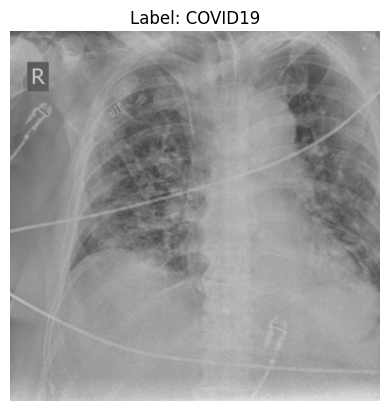

In [17]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

# Get the first image and its label
first_image, first_label = train_data[0]

# Convert the tensor image to PIL image for plotting
first_image = inverse_normalize(first_image)
to_pil = ToPILImage()
first_image_pil = to_pil(first_image)

# Plot the image
plt.imshow(np.array(first_image_pil))
plt.title(f"Label: {train_classes[first_label]}")
plt.axis('off')
plt.show()

In [18]:
len(train_data)

5144

In [19]:
len(valid_data)

1288

# Checking Imbalance Data

In [20]:
train_class_to_idx = train_data.class_to_idx
val_class_to_idx = valid_data.class_to_idx

In [21]:
train_class_counts = {class_name: 0 for class_name in train_class_to_idx}
valid_class_counts = {class_name: 0 for class_name in val_class_to_idx}

In [22]:
train_class_counts

{'COVID19': 0, 'NORMAL': 0, 'PNEUMONIA': 0}

In [23]:
train_idx_to_class = { text: label for text, label in enumerate(train_class_to_idx)}
val_idx_to_class = { text: label for text, label in enumerate(val_class_to_idx)}

train_idx_to_class

{0: 'COVID19', 1: 'NORMAL', 2: 'PNEUMONIA'}

In [24]:
# Count the number of instances per class in train_data
for _, label in train_data.imgs:
    class_name = train_idx_to_class[label]
    train_class_counts[class_name] += 1

# Count the number of instances per class in valid_data
for _, label in valid_data.imgs:
    class_name = val_idx_to_class[label]
    valid_class_counts[class_name] += 1

# Print the number of instances per class for train_data
print("Number of instances per class in train_data:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count}")

# Print the number of instances per class for valid_data
print("\nNumber of instances per class in valid_data:")
for class_name, count in valid_class_counts.items():
    print(f"{class_name}: {count}")

Number of instances per class in train_data:
COVID19: 460
NORMAL: 1266
PNEUMONIA: 3418

Number of instances per class in valid_data:
COVID19: 116
NORMAL: 317
PNEUMONIA: 855


In [25]:
len(train_data)

5144

# Actual Training

In [26]:
first_image.shape

torch.Size([3, 448, 448])

In [27]:
batch_size = 32
num_workers = 4


train_loader = DataLoader(train_data, batch_size = batch_size,
                          shuffle = True, num_workers = num_workers)
test_loader =  DataLoader(valid_data, batch_size= batch_size,
                          shuffle=True, num_workers = num_workers)

In [28]:
kernel_num_1 = 4
kernel_num_2 = 2
od_bottleneck = 3
temperature = 50
dropout = 0.1843255380611663
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.05

mb_v3 = mobilenetv3_small(num_classes = 3, od_bottleneck = od_bottleneck,
                             od_outside = 0, 
                          kernel_num_1 = kernel_num_1,
                            kernel_num_2 = kernel_num_2,
                            temperature = temperature,
                          use_od = True, drop_rate = dropout).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(mb_v3.parameters(), lr=learning_rate,
                            weight_decay = 0.00004, momentum = 0.9)

print(f"The number of parameters: {count_parameters(mb_v3)}")

Using Normal
Using OmniDimensional
Using OmniDimensional
Using OmniDimensional
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using OD
Using Normal
Using Normal
The number of parameters: 1619198


In [29]:
import logging
import os
from tqdm.notebook import tqdm

def check_logging_directory(path):
  parent_directory = os.path.dirname(path)
  if not os.path.exists(parent_directory):
    os.makedirs(parent_directory)
    print("Create new directory")

logging_path = './logging/chest_xray_omni_bayesian.log'
check_logging_directory(logging_path)

logging.basicConfig(filename=logging_path, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [30]:
def adjust_learning_rate(optimizer, epoch, total_epochs,
                         iteration, iter_per_epoch, initial_lr = 0.05):
    current_iter = iteration + epoch * iter_per_epoch
    max_iter = total_epochs * iter_per_epoch

    lr = initial_lr * (1 + np.cos(np.pi * current_iter / max_iter)) / 2

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def get_temperature(iteration, epoch, iter_per_epoch,
                        temp_epoch = 10, temp_init = 30.0):
    total_temp_iter = iter_per_epoch * temp_epoch
    current_iter = iteration + epoch * iter_per_epoch
    # print(current_iter)
    temperature = 1.0 + max(0, (temp_init - 1.0) * \
                            ((total_temp_iter - current_iter) / \
                            total_temp_iter))
    return temperature

In [31]:
from tqdm.notebook import tqdm

num_epochs = 100
# Huấn luyện mô hình
train_loss, val_loss = [], []
train_acc, val_acc = [], []

epoch_bar = tqdm(desc = 'Epoch',
                 total = num_epochs, position = 1)
train_bar = tqdm(desc = 'Training', total = len(train_loader),
                 position = 1, leave = True)
val_bar = tqdm(desc = 'Validation', total = len(test_loader),
               position = 1, leave = True)
print("🚀 Training MobileNetV3 - Omni Dimensional Dynamic Convolution 🚀")


for epoch in range(num_epochs):

    epoch_bar.set_description(f'Epoch {epoch + 1}/{num_epochs}')

    mb_v3.train()
    running_loss = 0.0
    running_acc = 0.0
    total_loss = 0.0
    total_acc = 0.0

    total = 0
    for i, (X, y) in enumerate(train_loader):


        if epoch < 50:
            temp = get_temperature(i + 1, epoch, len(train_loader),
                                   temp_epoch = 50, temp_init = temperature)
            mb_v3.net_update_temperature(temp)
            # print(f"The temperature is: {mb_v3.display_temperature()}")

        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)

        X, y_origin, y_sampled, lam = mixup_data(X, y, device,
                                                 alpha = 0.2)
        
        # Forward pass
        output = mb_v3(X)
        # loss = criterion(output, y)
        loss = mixup_criterion(criterion, output, y_origin, y_sampled, lam)

        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (i + 1)
        total_loss += loss_t

        # Backward pass
        loss.backward()
        optimizer.step()

        temp_lr = adjust_learning_rate(optimizer, epoch, 100,
                                       i + 1, len(train_loader),
                                       initial_lr = learning_rate)

        # Calculating the accuracy
        _, predicted = torch.max(output.data, 1)
        n_correct = (lam * predicted.eq(y_origin.data).cpu().sum().float()
                    + (1 - lam) * predicted.eq(y_sampled.data).cpu().sum().float())
        # n_correct = (predicted == y).sum().item()
        acc_t = n_correct / len(predicted) * 100
        running_acc += (acc_t - running_acc) / (i + 1)

        total_acc += n_correct
        total += y.shape[0]

        train_bar.set_postfix(loss = running_loss,
                              acc = f"{running_acc:.2f}%",
                              epoch = epoch + 1)
        train_bar.update()

    current_loss = total_loss / len(train_loader)
    current_acc = total_acc / total * 100
    train_loss.append(current_loss)
    train_acc.append(current_acc)

    print("========================================")
    print("\033[1;34m" + f"Epoch {epoch + 1}/{num_epochs}" + "\033[0m")
    print(f"Train Loss: {current_loss:.2f}\t|\tTrain Acc: {current_acc:.2f}%")
    logging.info("========================================")
    logging.info(f"Epoch {epoch + 1}/{num_epochs}")
    logging.info(f"Train Loss: {current_loss:.2f}")
    logging.info(f"Train Acc: {current_acc:.2f}")
    
    # Eval trên valid set
    running_loss = 0.0
    running_acc = 0.0
    total_loss = 0.0
    total_acc = 0.0

    total = 0
    mb_v3.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(test_loader):

            X, y = X.to(device), y.to(device)
            # Forward pass
            output = mb_v3(X)

            # Calculate Loss
            loss = criterion(output, y)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (i + 1)
            total_loss += loss_t

            # Calculate Accuracies
            _, predicted = torch.max(output.data, 1)
            n_correct = (predicted == y).sum().item()
            acc_t = n_correct / len(predicted) * 100
            running_acc += (acc_t - running_acc) / (i + 1)
            total_acc += n_correct

            total += y.shape[0]

            val_bar.set_postfix(loss = running_loss,
                                acc = f"{running_acc:.2f}%",
                                epoch = epoch + 1)
            val_bar.update()

    current_loss = total_loss / len(test_loader)
    current_acc = total_acc / total * 100

    val_loss.append(current_loss)
    val_acc.append(current_acc)

    print(f"Val Loss: {current_loss:.2f}\t|\tVal Acc: {current_acc:.2f}%")
    logging.info(f"Val Loss: {current_loss:.2f}")
    logging.info(f"Val Acc: {current_acc:.2f}")
    
    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.update()

    if epoch < 50:
        temperature = mb_v3.display_temperature()
        print(f"The current temperature is: {temperature}")

    print(f"The current learning rate is: {temp_lr}")


print("========================================")
print("Training Completed! 😀")


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/161 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

🚀 Training MobileNetV3 - Omni Dimensional Dynamic Convolution 🚀
Epoch 1/100
Train Loss: 0.57	|	Train Acc: 77.87%
Val Loss: 0.41	|	Val Acc: 85.09%
The current temperature is: 49.019999999999996
The current learning rate is: 0.04998766400914329
Epoch 2/100
Train Loss: 0.40	|	Train Acc: 85.31%
Val Loss: 0.30	|	Val Acc: 89.75%
The current temperature is: 47.099199999999996
The current learning rate is: 0.04995066821070679
Epoch 3/100
Train Loss: 0.37	|	Train Acc: 87.14%
Val Loss: 0.46	|	Val Acc: 82.30%
The current temperature is: 44.33324799999999
The current learning rate is: 0.049889049115077
Epoch 4/100
Train Loss: 0.33	|	Train Acc: 88.55%
Val Loss: 0.22	|	Val Acc: 92.55%
The current temperature is: 40.86658815999999
The current learning rate is: 0.04980286753286195
Epoch 5/100
Train Loss: 0.33	|	Train Acc: 89.32%
Val Loss: 0.20	|	Val Acc: 95.03%
The current temperature is: 36.879929344
The current learning rate is: 0.04969220851487845
Epoch 6/100
Train Loss: 0.31	|	Train Acc: 89.91%
Va

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Val Loss: 0.13	|	Val Acc: 96.35%
The current learning rate is: 0.005737168930605272
Epoch 79/100
Train Loss: 0.15	|	Train Acc: 95.21%
Val Loss: 0.10	|	Val Acc: 96.66%
The current learning rate is: 0.00524612469060774
Epoch 80/100
Train Loss: 0.17	|	Train Acc: 93.73%
Val Loss: 0.11	|	Val Acc: 96.58%
The current learning rate is: 0.004774575140626317
Epoch 81/100
Train Loss: 0.17	|	Train Acc: 93.61%
Val Loss: 0.12	|	Val Acc: 96.51%
The current learning rate is: 0.004322985643135951
Epoch 82/100
Train Loss: 0.14	|	Train Acc: 95.44%
Val Loss: 0.11	|	Val Acc: 96.20%
The current learning rate is: 0.0038918018624496233
Epoch 83/100
Train Loss: 0.15	|	Train Acc: 95.19%
Val Loss: 0.13	|	Val Acc: 96.27%
The current learning rate is: 0.003481449324901412
Epoch 84/100
Train Loss: 0.15	|	Train Acc: 94.79%
Val Loss: 0.13	|	Val Acc: 96.20%
The current learning rate is: 0.0030923329989034107
Epoch 85/100
Train Loss: 0.17	|	Train Acc: 94.27%
Val Loss: 0.12	|	Val Acc: 96.89%
The current learning rate is

In [32]:
logging.info("END========================================")